# Real Morphologies

Examples of growing realistic morphologies:
- Motor neurons of the spinal cord: [Motor neuron](#Motor_neuron)
- Cortex layer 5 pyramidal neuron: [L5 pyramidal neuron](#L5_pyramidal_neuron)
- A forest of layer 5 pyramidal neurons: [L5 pyramidal forest](#L5_pyramidal_forest)

## Motor_neuron
Generates a spinal cord motor neuron morphology as in Figure 2 of [Torben-Nielsen, B. & De Schutter, E. (2014) Context-aware modeling of neuronal morphologies. Frontiers in Neuroanatomy, 8, 92](https://www.frontiersin.org/articles/10.3389/fnana.2014.00092/full).  
This script is a new version using updated growth rules based on extensive data analysis of the Cullheim et al., 1987 and the Alvarez et al., 1998 data sets used in the previous study.

<IPython.core.display.Javascript object>


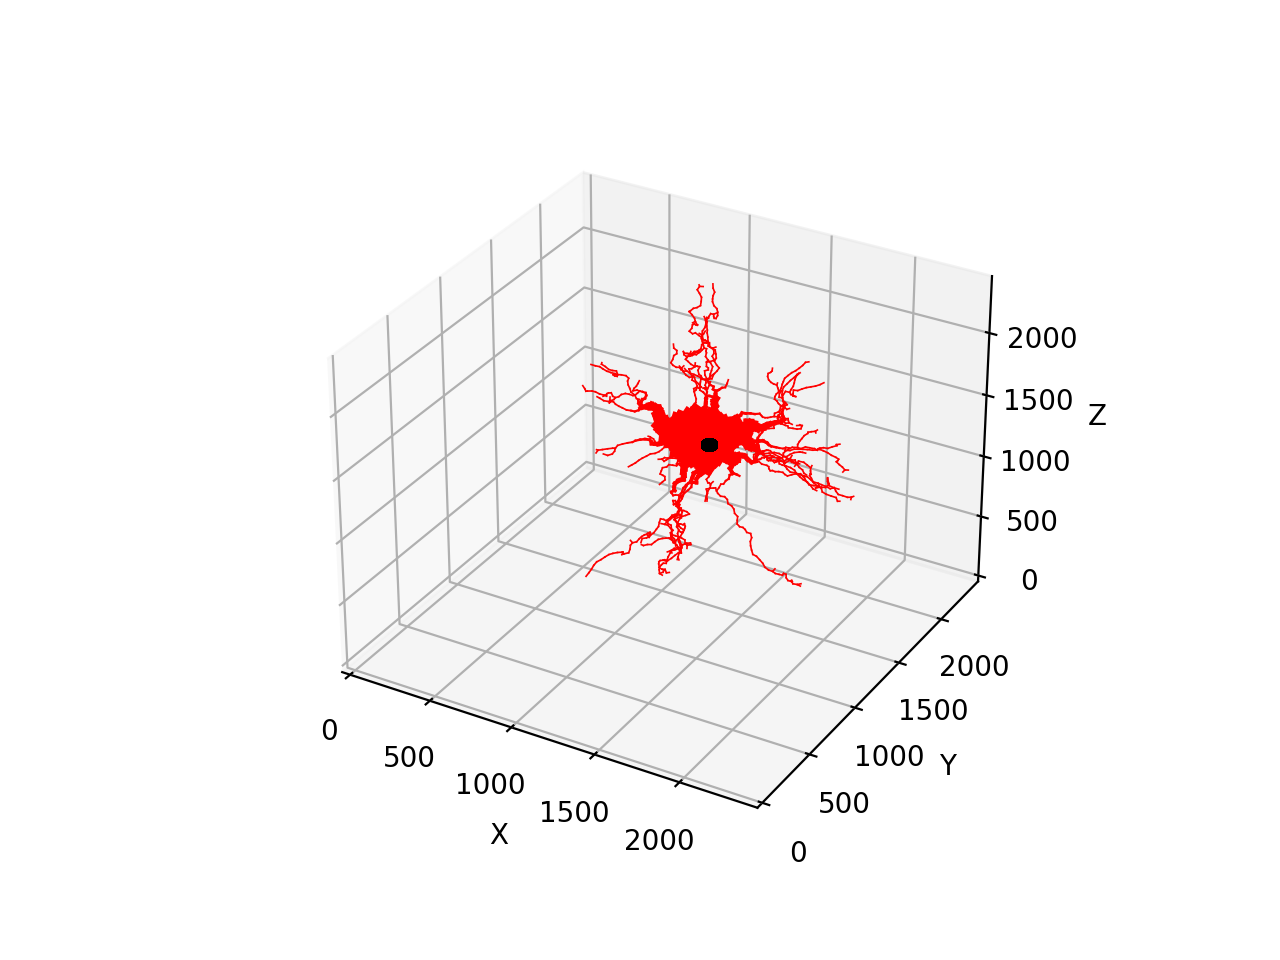

In [2]:
%matplotlib notebook 

from neurodevsim.simulator import *

class MotorNeuronFront(Front):
    _fields_ = Front._fields_ + [('branch_length', c_double),('max_branch_len',c_double)]
    
    def manage_front(self,constellation):
         
        if self.swc_type == 1: # this is the soma
            tot_dendr = int(np.random.normal(11,2)) # random number of dendrites used
            num_dendr = 0 # number of dendrites made
            rnd_dirs = self.unit_branching_sample(18)  # generate many vectors
            for i in range(18):
                # random radius 
                rad = 0.
                while rad < 1.:
                    rad = np.random.normal(4.3,1.9)
                # end coordinate of dendritic root
                new_pos = self.end + rnd_dirs[i] * (20. + self.radius)
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=3) # make a new front and store it
                    new_front.branch_length = new_front.length() # compute path length between branch points
                    new_front.max_branch_len = np.random.normal(1081,330) # max length of this branch
                    num_dendr += 1
                    if num_dendr == tot_dendr: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # less than tot_dendr dendrites made
            #   make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        else:
            # terminate this branch?
            if self.path_length >= self.max_branch_len:
                self.disable(constellation) # stop growing
                return
            # follow a data fitted branching rule in all other cases
            min_branch_len = 83 + self.order * 8 # increases with order
            if self.branch_length >= min_branch_len: # fixed probability of branching beyond certain length
                bif_prob = 20. / (214 - self.order * 9) # increases with order
            else: # very low probability of branching
                bif_prob = 0.01
            if np.random.random() > bif_prob: # extend a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 5:
                    # random component along current heading
                    rnd_dir = self.unit_heading_sample()
                    # soma-tropism, sample direction away from the soma
                    soma_dir = self.end - self.get_soma(constellation).orig
                    # combine all influences on the new direction of growth
                    new_dir = rnd_dir * 1.0 + soma_dir.norm() * 0.4
                    new_pos = self.end + new_dir * 20
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                        new_front.branch_length = self.branch_length + new_front.length()
                        new_front.max_branch_len = self.max_branch_len
                        # make front inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # done for this cycle
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                # did not grow
                if constellation.cycle - self.birth > 2: # mutiple failed attempts
                    self.disable(constellation) # stop trying
            else: # branch a front: generate two child fronts
                # strongly taper radius
                rad = self.taper(0.7)
                num_dendr = 0 # number of dendrites made
                rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                for p in rnd_dirs: # make 2 branches
                    new_pos = self.end + p * 20.
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                        new_front.branch_length = new_front.length() # compute path length between branch points                        num_dendr += 1
                        new_front.max_branch_len = np.random.normal(1081,330) # max length of this branch
                        num_dendr += 1
                        if num_dendr == 2: # enough dendrites made
                            # make front inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            return # done for this cycle
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                # did not branch
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/motor_neuron.db"
    sim_volume = [[0., 0., 0.], [2400., 2400., 2400.]]
    neuron_types = [MotorNeuronFront]
    # use larger grid_step to conform to long fronts
    admin = Admin_agent(4,fname,sim_volume,neuron_types,grid_step=30.,max_active=4000,verbose=0,plot=True)

    # make soma and set neuron name
    radius = np.random.normal(45,10)
    admin.add_neurons(MotorNeuronFront,"motor_neuron",1,[[1000.0,1000.0,1000.0],[1400.,1400.,1400.]],radius)

    # run the simulation
    admin.simulation_loop(80)

    # clean up
    admin.destruction()

## L5_pyramidal_neuron
Approximates a cortical layer 5 pyramidal neuron morphology as in Figure 4 of [Torben-Nielsen, B. & De Schutter, E. (2014) Context-aware modeling of neuronal morphologies. Frontiers in Neuroanatomy, 8, 92](https://www.frontiersin.org/articles/10.3389/fnana.2014.00092/full).  
This script is a new version using updated growth rules. It has not been refitted to experimental data yet and therefore not all morphologies may look "real".

<IPython.core.display.Javascript object>


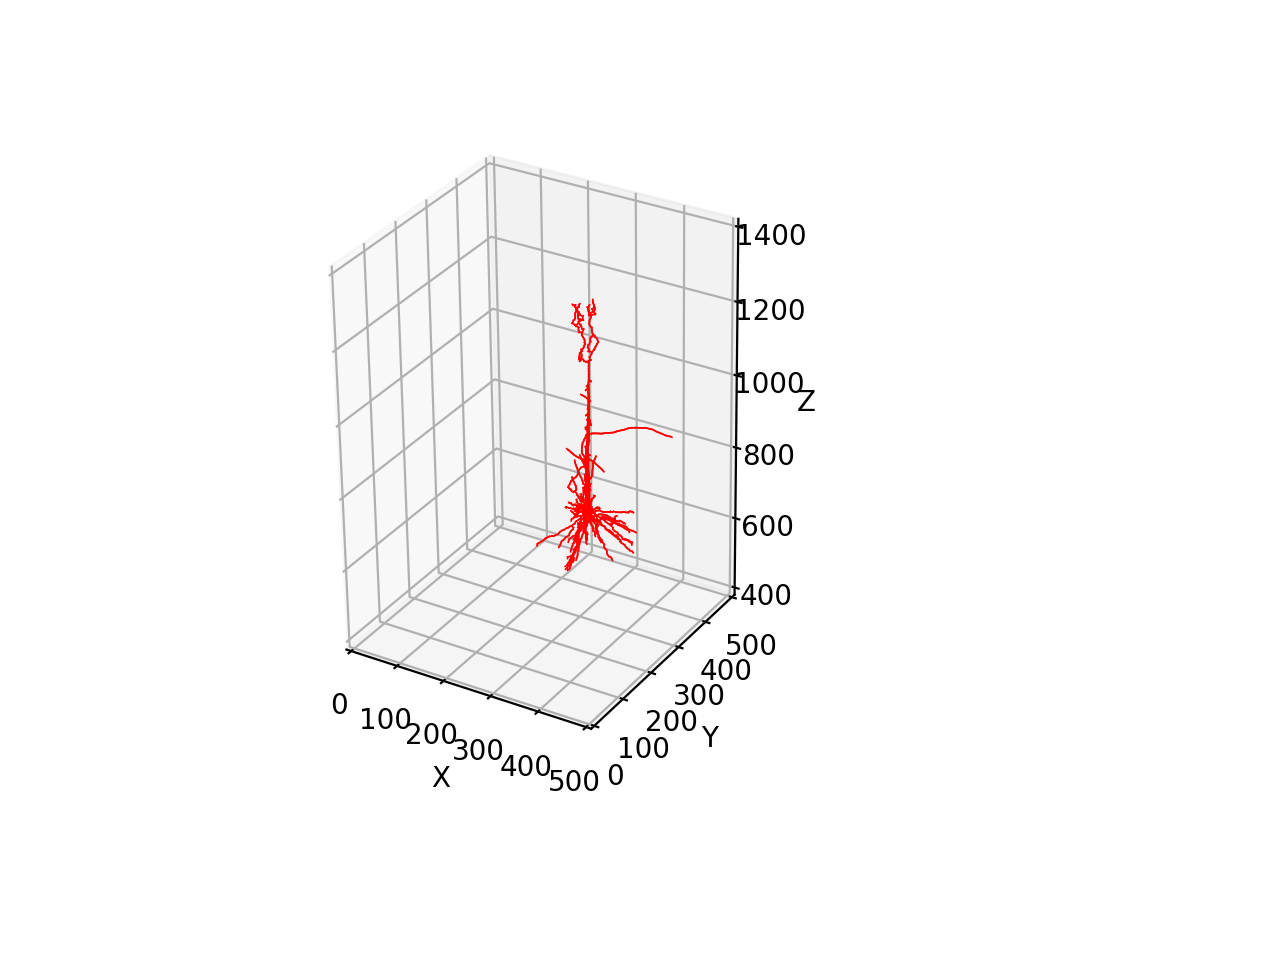

In [3]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np
import random

pia = 1420 # z location of the pia attraction plane
Pia_dir = Point(0.,0.,1.)
No_dir = Point(0.,0.,0.)

# Define the growth processes for the simulation
#  Make a new class for this simulation derived from Front
class L5PyramidalFront(Front):
    _fields_ = Front._fields_ + [('layer',c_short), ('start_order_L3',c_short), \
                                 ('start_order_L2',c_short), ('root_length',c_double)]
    # layer: encodes which cortical layer the front belongs to
    # start_order_L3: order when apical branch entered layer 3
    # start_order_L2: order when apical or tuft branch entered layer 2
    # root_length: path_length at root of oblique dendrite
    # status1: encodes no_branching condition
    
    # returns layer the front is in
    def get_layer(self):
        if self.end.z < 471:
            return 6
        elif self.end.z < 826:
            return 5
        elif self.end.z < 1090:
            return 4
        elif self.end.z < 1192:
            return 3
        elif self.end.z < 1311:
            return 2
        else:
            return 1

    def manage_front(self,constellation):
        if self.order == 0: # this is the soma
            self.create_apical_branch(constellation)
            self.create_basal_branches(constellation)
            self.disable(constellation) # make soma inactive
        elif self.swc_type == 3: # basal dendrite
            if constellation.cycle <= np.random.randint(27,40):
                self.extend_basal_front(constellation)
            else:
                self.disable(constellation) # stop growing
        elif self.swc_type == 4: # apical dendrite
            if constellation.cycle <= 100:
                if self.num_children == 0: # extend
                    self.extend_apical_front(constellation)
                else: # maybe make oblique dendrite
                    self.create_oblique_branch(constellation)
            else:
                self.disable(constellation) # stop growing
        elif self.swc_type == 8: # oblique dendrite
            self.extend_oblique_front(constellation)
        elif self.swc_type == 9: # oblique dendrite
            self.extend_tuft_front(constellation)
        else:
            print ("ERROR: unknown swc_type",self.swc_type)

    def create_apical_branch(self,constellation):
        count = 0 # counts number of add_child trials
        new_pos = self.orig + Pia_dir * (self.radius + 7.) # grow straight to pia
        while count < 10:
            # check for possible errors, mainly GridCompetitionError
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.0,branch_name="apical dendrite",swc_type=4)
                new_front.layer = new_front.get_layer()
                return
            except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                count += 1
                continue # pick another new_pos, no attempt to correct the error

    def create_basal_branches(self,constellation):
        num_basal = np.random.randint(5,11) # number of dendrites to grow
        num_dendr = 0  # number of dendrites grown
        rnd_dirs = self.unit_branching_sample(20)  # generate many vectors
        for p in rnd_dirs:
            if p.z > -0.1:
                continue # ignore upward points
            new_pos = self.orig + p * (self.radius + 7.)
            count = 0
            while count < 10:
                # check for possible errors, mainly GridCompetitionError
                try:
                    new_front = self.add_child(constellation,new_pos,radius=0.3,\
                                                branch_name="basal dendrite",swc_type=3)
                    new_front.layer = new_front.get_layer()
                    num_dendr += 1
                    if num_dendr == num_basal: # made all branches
                        return
                    else:
                        break
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

    def create_oblique_branch(self,constellation):
        # make an oblique dendrite with some probability (and extend the main branch)
        if self.layer == 4: # TODO: check parameters
            oblique_prob = 0.015  # reduced by 20 for repeated testing 
        else:  
            oblique_prob =  0.006 # layer 5
        if np.random.random() < oblique_prob: # make oblique dendrite
            count = 0
            while count < 5:
                rnd_dir = self.unit_heading_sample(mean=90,width=10) # close to horizontal
                new_pos = self.orig + rnd_dir * 5.
                # check for possible errors
                try:
                    new_front = self.add_child(constellation,new_pos,radius=0.3,\
                                                branch_name="oblique dendrite",swc_type=8)
                    new_front.layer = new_front.get_layer()
                    new_front.root_length = self.path_length # store path_length at root of oblique
                    self.disable(constellation) # do not grow another oblique
                    # stop interstitial branching within 10 µm distance
                    neighbors = self.get_neighbors(constellation,10.,branch_stop=True)
                    for front in neighbors:
                        if front.is_active():
                            front.disable(constellation) # stop interstitial growth
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            
    def extend_basal_front(self,constellation):
        if self.is_status1(): # no_branch
            bif_prob = 0.
        else:
            if self.order < 6:
                bif_prob = 0.78 / (2. * self.order)
            else:
                bif_prob = 0.
            if self.order >= 2 and np.random.random() < 0.07:
                self.set_status1() # no_branch
                bif_prob = 0.
        if np.random.random() > bif_prob:
            if self.order <= 6:
                term_prob = 0.01 * self.order
            else: 
                term_prob = 0.2
            if np.random.random() < term_prob:
                self.disable(constellation)  # terminate growth
                return
            # extend basal dendrite
            #  compute direction vectors
            #    grow away from soma
            soma = self.get_soma(constellation)
            soma_dir = (soma.orig - self.end).norm()
            #    repulsed by other fronts from same neuron
            eigen_fronts = self.get_fronts(constellation,what="self",max_distance=25.,swc_types=[3])
            #    compute repulsion, exponentially decaying over distance for nearest fronts
            if eigen_fronts:
                strength = (5./self.order) * np.exp(-0.05 * eigen_fronts[0][1]) / eigen_fronts[0][1]
                if strength < 0.2:
                    eigen_dir = No_dir # no repulsion
                else:
                    eigen_dir = (eigen_fronts[0][0].end - self.end).norm() * strength
            else:
                eigen_dir = No_dir # no repulsion
            count = 0
            rad = self.taper(0.98)
            while count < 5:
                heading = self.unit_heading_sample(width=20.) # TODO: find proper width
                new_dir = heading - soma_dir * 0.8 - eigen_dir
                new_pos = self.orig + new_dir.norm() * 8.
                # check for possible errors, mainly GridCompetitionError
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    new_front.layer = new_front.get_layer()
                    if self.is_status1():
                        new_front.set_status1() # no_branch
                    self.disable(constellation)
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            if constellation.cycle - self.birth > 2: # mutiple failed attempts
                self.disable(constellation) # stop trying
        else: # branch
            rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
            rad = self.taper(0.98)
            num_dendr = 0 # number of dendrites made
            for p in rnd_dirs: # make 2 branches
                new_pos = self.end + p * 5.
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    new_front.layer = new_front.get_layer()
                    num_dendr += 1
                    if num_dendr == 2: # enough dendrites made
                        self.disable(constellation)
                        return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # did not branch
            if self.num_children > 0: # single child made -> make front inactive
                self.disable(constellation)

    def extend_apical_front(self,constellation):
        if pia - self.end.z < 10.:
            self.disable(constellation) # terminate
            return 

        if self.layer == 6: # should never happen
            print ("ERROR: apical dendrite growing into layer 6")
            self.disable(constellation)
            return

        if self.layer == 3: # can bifurcate into tuft dendrite
            bif_prob = 0.17
        elif self.layer <= 2:
            bif_prob = 0.4
        else: # layers 5 & 4
            bif_prob = 0.

        if np.random.random() >= bif_prob: # extend apical dendrite
            count = 0 # counts number of add_child trials
            rad = self.taper(0.98)
            while count < 5:
                heading = self.unit_heading_sample(width=5.) # TODO: find proper width
                new_pos = self.end + (Pia_dir + heading) * 3.5 # grow to pia
                # check for possible errors
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if (self.layer == 4) and (layer == 3):
                        self.start_order_L3 = self.order
                    elif self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                    if layer < 4:
                        self.disable(constellation) # no oblique growth
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
        else: # bifurcate
            num_dendr = 0 # number of dendrites made
            rnd_dirs = self.unit_branching_sample(8) # generate more points than needed
            rad = self.taper(0.98)
            for p in rnd_dirs: # make 2 branches
                new_pos = self.end + p * 7.
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad,\
                                                branch_name="tuft dendrite",swc_type=9)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                    num_dendr += 1
                    if num_dendr == 2: # enough dendrites made
                        self.disable(constellation)
                        return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # did not branch
            if self.num_children > 0: # single child made -> make front inactive
                self.disable(constellation)
                
    def extend_oblique_front(self,constellation):
        # extend or terminate the oblique
        if ((self.path_length - self.root_length) > 150.) and np.random.random() < 0.1:
            self.disable(constellation) # stop growth
        else:
            count = 0
            rad = self.taper(0.98)
            while count < 5:
                rnd_dir = self.unit_heading_sample(width=5.) # TODO: find width
                new_pos = self.orig + rnd_dir * 7.
                # check for possible errors
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    new_front.layer = new_front.get_layer()
                    new_front.root_length = new_front.root_length
                    self.disable(constellation)
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                    
    def extend_tuft_front(self,constellation):
        # layer specific probability to terminate and compute bifurcation probability
        if self.layer == 3: 
            if (np.random.random() < 0.01) and (self.order - self.start_order_L3 >= 3):
                self.disable(constellation) # stop growing
                return
            bif_prob = 0.1
            if self.order - self.start_order_L3 >= 3:
                bif_prob = 0.
            eigen_repulse = 2.0 + 2.0 * np.random.random()
            pia_repulse = 3.5
        elif self.layer == 2: 
            if np.random.random() < 0.03:
                self.disable(constellation) # stop growing
                return
            bif_prob = 0.08
            if self.order - self.start_order_L3 <= 2:
                bif_prob = 0.4
            elif self.order - self.start_order_L2 >= (3 + 2 * np.random.random()):
                bif_prob = 0.
            eigen_repulse = 0.5 + np.random.random()
            pia_repulse = 2.8
        else: # layer 1
            if np.random.random() < 0.06:
                self.disable(constellation) # stop growing
                return
            if self.is_status1(): # no_branching
                bif_prob = 0.
            else:
                bif_prob = 0.08
                if self.order - self.start_order_L3 <= 4:
                    bif_prob = 0.3
            eigen_repulse = np.random.random()
            pia_repulse = 2.1

        if np.random.random() >= bif_prob: # simply extend
            #  compute direction vectors
            #    repulsed by other fronts from same neuron
            eigen_fronts = self.get_fronts(constellation,what="self",max_distance=25.)
            #    compute repulsion, exponentially decaying over distance for nearest fronts
            if eigen_fronts:
                eigen_strength = eigen_repulse * np.exp(-0.015 * eigen_fronts[0][1]) / eigen_fronts[0][1]
                if eigen_strength < 0.2:
                    eigen_dir = No_dir # no repulsion
                else:
                    eigen_dir = (eigen_fronts[0][0].end - self.end).norm() * eigen_strength
            else:
                eigen_dir = No_dir # no repulsion
            #   attracted by pia
            pia_distance = pia - self.end.z
            pia_strength = pia_repulse * np.exp(-0.015 * pia_distance) / pia_distance
            if pia_strength < 0.2:
                pia_rep = No_dir # no repulsion
            else:
                pia_rep = (Point(self.end.x,self.end.y,pia) - self.end).norm() * pia_strength
            count = 0
            rad = self.taper(0.98)
            while count < 5:
                heading = self.unit_heading_sample(width=20.) # TODO: find proper width
                if heading.z < 0.: # prevent downward or close to horizontal directions
                    heading.z = 0.1
                new_dir = heading - eigen_dir + Pia_dir * 0.4 - pia_rep
                new_pos = self.orig + new_dir.norm() * 7.
                # check for possible errors, mainly GridCompetitionError
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if (self.layer == 4) and (layer == 3):
                        self.start_order_L3 = self.order
                    elif self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                    if self.is_status1():
                        new_front.set_status1() # no_branch
                    self.disable(constellation)
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            if constellation.cycle - self.birth > 2: # mutiple failed attempts
                self.disable(constellation) # stop trying 
        else: # bifurcate
            rnd_dirs = self.unit_branching_sample(8) # generate more points than needed
            rad = self.taper(0.98)
            num_dendr = 0 # number of dendrites made
            for p in rnd_dirs: # make 2 branches
                new_pos = self.end + p * 7.
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                        if self.layer == 1: # only one branch point allowed in layer 1
                            new_front.set_status1()
                    num_dendr += 1
                    if num_dendr == 2: # enough dendrites made
                        self.disable(constellation)
                        return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # did not branch
            if self.num_children > 0: # single child made -> make front inactive
                self.disable(constellation)

# Initialize and run the simulation
if __name__=="__main__":

    # initialize Admin_agent
    fname = "output/L5pyramidal_neuron.db"
    sim_volume = [[0., 0., 400.], [500.,500.,1400.]]
    neuron_types = [L5PyramidalFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True,scale_axis=[0.6,0.6,1.2],soma_black=False)
    
    # make soma and set neuron name
    admin.add_neurons(L5PyramidalFront,"L5PyramidalFront",1,[[250,250,560],[350,350,826]],10.)

    # run the simulaton
    admin.simulation_loop(115)

    # clean up before quitting
    admin.destruction()

## L5_pyramidal_forest
A forest of 100 cortical layer 5 pyramidal neurons as in Figure 4C of [Torben-Nielsen, B. & De Schutter, E. (2014) Context-aware modeling of neuronal morphologies. Frontiers in Neuroanatomy, 8, 92](https://www.frontiersin.org/articles/10.3389/fnana.2014.00092/full).  

If the hardware has more than 6 cores it is worthwhile to increase the number of processes used to run this as it is fairly slow using 4 processes.

<IPython.core.display.Javascript object>


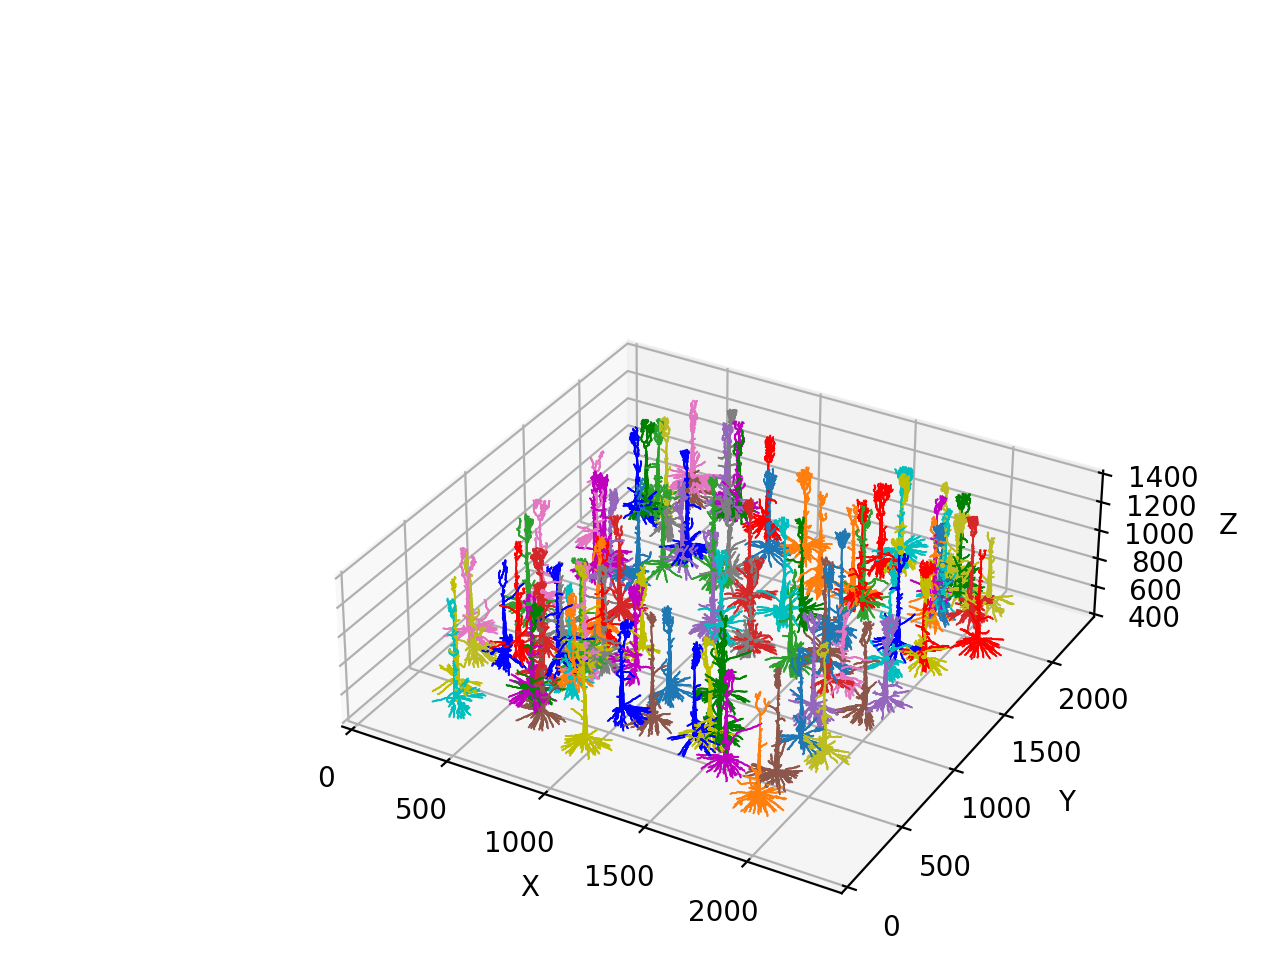

In [4]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np
import random

pia = 1420 # z location of the pia attraction plane
Pia_dir = Point(0.,0.,1.)
No_dir = Point(0.,0.,0.)

# Define the growth processes for the simulation
#  Make a new class for this simulation derived from Front
class L5PyramidalFront(Front):
    _fields_ = Front._fields_ + [('layer',c_short), ('start_order_L3',c_short), \
                                 ('start_order_L2',c_short), ('root_length',c_double)]
    # layer: encodes which cortical layer the front belongs to
    # start_order_L3: order when apical branch entered layer 3
    # start_order_L2: order when apical or tuft branch entered layer 2
    # root_length: path_length at root of oblique dendrite
    # status1: encodes no_branching condition
    
    # returns layer the front is in
    def get_layer(self):
        if self.end.z < 471:
            return 6
        elif self.end.z < 826:
            return 5
        elif self.end.z < 1090:
            return 4
        elif self.end.z < 1192:
            return 3
        elif self.end.z < 1311:
            return 2
        else:
            return 1

    def manage_front(self,constellation):
        if self.order == 0: # this is the soma
            self.create_apical_branch(constellation)
            self.create_basal_branches(constellation)
            self.disable(constellation) # make soma inactive
        elif self.swc_type == 3: # basal dendrite
            if constellation.cycle <= np.random.randint(27,40):
                self.extend_basal_front(constellation)
            else:
                self.disable(constellation) # stop growing
        elif self.swc_type == 4: # apical dendrite
            if constellation.cycle <= 100:
                if self.num_children == 0: # extend
                    self.extend_apical_front(constellation)
                else: # maybe make oblique dendrite
                    self.create_oblique_branch(constellation)
            else:
                self.disable(constellation) # stop growing
        elif self.swc_type == 8: # oblique dendrite
            self.extend_oblique_front(constellation)
        elif self.swc_type == 9: # oblique dendrite
            self.extend_tuft_front(constellation)
        else:
            print ("ERROR: unknown swc_type",self.swc_type)

    def create_apical_branch(self,constellation):
        count = 0 # counts number of add_child trials
        new_pos = self.orig + Pia_dir * (self.radius + 7.) # grow straight to pia
        while count < 10:
            # check for possible errors, mainly GridCompetitionError
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.0,branch_name="apical dendrite",swc_type=4)
                new_front.layer = new_front.get_layer()
                return
            except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                count += 1
                continue # pick another new_pos, no attempt to correct the error

    def create_basal_branches(self,constellation):
        num_basal = np.random.randint(5,11) # number of dendrites to grow
        num_dendr = 0  # number of dendrites grown
        rnd_dirs = self.unit_branching_sample(20)  # generate many vectors
        for p in rnd_dirs:
            if p.z > -0.1:
                continue # ignore upward points
            new_pos = self.orig + p * (self.radius + 7.)
            count = 0
            while count < 10:
                # check for possible errors, mainly GridCompetitionError
                try:
                    new_front = self.add_child(constellation,new_pos,radius=0.3,\
                                                branch_name="basal dendrite",swc_type=3)
                    new_front.layer = new_front.get_layer()
                    num_dendr += 1
                    if num_dendr == num_basal: # made all branches
                        return
                    else:
                        break
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

    def create_oblique_branch(self,constellation):
        # make an oblique dendrite with some probability (and extend the main branch)
        if self.layer == 4: # TODO: check parameters
            oblique_prob = 0.015  # reduced by 20 for repeated testing 
        else:  
            oblique_prob =  0.006 # layer 5
        if np.random.random() < oblique_prob: # make oblique dendrite
            count = 0
            while count < 5:
                rnd_dir = self.unit_heading_sample(mean=90,width=10) # close to horizontal
                new_pos = self.orig + rnd_dir * 5.
                # check for possible errors
                try:
                    new_front = self.add_child(constellation,new_pos,radius=0.3,\
                                                branch_name="oblique dendrite",swc_type=8)
                    new_front.layer = new_front.get_layer()
                    new_front.root_length = self.path_length # store path_length at root of oblique
                    self.disable(constellation) # do not grow another oblique
                    # stop interstitial branching within 10 µm distance
                    neighbors = self.get_neighbors(constellation,10.,branch_stop=True)
                    for front in neighbors:
                        if front.is_active():
                            front.disable(constellation) # stop interstitial growth
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            
    def extend_basal_front(self,constellation):
        if self.is_status1(): # no_branch
            bif_prob = 0.
        else:
            if self.order < 6:
                bif_prob = 0.78 / (2. * self.order)
            else:
                bif_prob = 0.
            if self.order >= 2 and np.random.random() < 0.07:
                self.set_status1() # no_branch
                bif_prob = 0.
        if np.random.random() > bif_prob:
            if self.order <= 6:
                term_prob = 0.01 * self.order
            else: 
                term_prob = 0.2
            if np.random.random() < term_prob:
                self.disable(constellation)  # terminate growth
                return
            # extend basal dendrite
            #  compute direction vectors
            #    grow away from soma
            soma = self.get_soma(constellation)
            soma_dir = (soma.orig - self.end).norm()
            #    repulsed by other fronts from same neuron
            eigen_fronts = self.get_fronts(constellation,what="self",max_distance=25.,swc_types=[3])
            #    compute repulsion, exponentially decaying over distance for nearest fronts
            if eigen_fronts:
                strength = (5./self.order) * np.exp(-0.05 * eigen_fronts[0][1]) / eigen_fronts[0][1]
                if strength < 0.2:
                    eigen_dir = No_dir # no repulsion
                else:
                    eigen_dir = (eigen_fronts[0][0].end - self.end).norm() * strength
            else:
                eigen_dir = No_dir # no repulsion
            count = 0
            rad = self.taper(0.98)
            while count < 5:
                heading = self.unit_heading_sample(width=20.) # TODO: find proper width
                new_dir = heading - soma_dir * 0.8 - eigen_dir
                new_pos = self.orig + new_dir.norm() * 8.
                # check for possible errors, mainly GridCompetitionError
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    new_front.layer = new_front.get_layer()
                    if self.is_status1():
                        new_front.set_status1() # no_branch
                    self.disable(constellation)
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            if constellation.cycle - self.birth > 2: # mutiple failed attempts
                self.disable(constellation) # stop trying
        else: # branch
            rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
            rad = self.taper(0.98)
            num_dendr = 0 # number of dendrites made
            for p in rnd_dirs: # make 2 branches
                new_pos = self.end + p * 5.
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    new_front.layer = new_front.get_layer()
                    num_dendr += 1
                    if num_dendr == 2: # enough dendrites made
                        self.disable(constellation)
                        return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # did not branch
            if self.num_children > 0: # single child made -> make front inactive
                self.disable(constellation)

    def extend_apical_front(self,constellation):
        if pia - self.end.z < 10.:
            self.disable(constellation) # terminate
            return 

        if self.layer == 6: # should never happen
            print ("ERROR: apical dendrite growing into layer 6")
            self.disable(constellation)
            return

        if self.layer == 3: # can bifurcate into tuft dendrite
            bif_prob = 0.17
        elif self.layer <= 2:
            bif_prob = 0.4
        else: # layers 5 & 4
            bif_prob = 0.

        if np.random.random() >= bif_prob: # extend apical dendrite
            count = 0 # counts number of add_child trials
            rad = self.taper(0.98)
            while count < 5:
                heading = self.unit_heading_sample(width=5.) # TODO: find proper width
                new_pos = self.end + (Pia_dir + heading) * 3.5 # grow to pia
                # check for possible errors
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if (self.layer == 4) and (layer == 3):
                        self.start_order_L3 = self.order
                    elif self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                    if layer < 4:
                        self.disable(constellation) # no oblique growth
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
        else: # bifurcate
            num_dendr = 0 # number of dendrites made
            rnd_dirs = self.unit_branching_sample(8) # generate more points than needed
            rad = self.taper(0.98)
            for p in rnd_dirs: # make 2 branches
                new_pos = self.end + p * 7.
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad,\
                                                branch_name="tuft dendrite",swc_type=9)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                    num_dendr += 1
                    if num_dendr == 2: # enough dendrites made
                        self.disable(constellation)
                        return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # did not branch
            if self.num_children > 0: # single child made -> make front inactive
                self.disable(constellation)
                
    def extend_oblique_front(self,constellation):
        # extend or terminate the oblique
        if ((self.path_length - self.root_length) > 150.) and np.random.random() < 0.1:
            self.disable(constellation) # stop growth
        else:
            count = 0
            rad = self.taper(0.98)
            while count < 5:
                rnd_dir = self.unit_heading_sample(width=5.) # TODO: find width
                new_pos = self.orig + rnd_dir * 7.
                # check for possible errors
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    new_front.layer = new_front.get_layer()
                    new_front.root_length = new_front.root_length
                    self.disable(constellation)
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                    
    def extend_tuft_front(self,constellation):
        # layer specific probability to terminate and compute bifurcation probability
        if self.layer == 3: 
            if (np.random.random() < 0.01) and (self.order - self.start_order_L3 >= 3):
                self.disable(constellation) # stop growing
                return
            bif_prob = 0.1
            if self.order - self.start_order_L3 >= 3:
                bif_prob = 0.
            eigen_repulse = 2.0 + 2.0 * np.random.random()
            pia_repulse = 3.5
        elif self.layer == 2: 
            if np.random.random() < 0.03:
                self.disable(constellation) # stop growing
                return
            bif_prob = 0.08
            if self.order - self.start_order_L3 <= 2:
                bif_prob = 0.4
            elif self.order - self.start_order_L2 >= (3 + 2 * np.random.random()):
                bif_prob = 0.
            eigen_repulse = 0.5 + np.random.random()
            pia_repulse = 2.8
        else: # layer 1
            if np.random.random() < 0.06:
                self.disable(constellation) # stop growing
                return
            if self.is_status1(): # no_branching
                bif_prob = 0.
            else:
                bif_prob = 0.08
                if self.order - self.start_order_L3 <= 4:
                    bif_prob = 0.3
            eigen_repulse = np.random.random()
            pia_repulse = 2.1

        if np.random.random() >= bif_prob: # simply extend
            #  compute direction vectors
            #    repulsed by other fronts from same neuron
            eigen_fronts = self.get_fronts(constellation,what="self",max_distance=25.)
            #    compute repulsion, exponentially decaying over distance for nearest fronts
            if eigen_fronts:
                eigen_strength = eigen_repulse * np.exp(-0.015 * eigen_fronts[0][1]) / eigen_fronts[0][1]
                if eigen_strength < 0.2:
                    eigen_dir = No_dir # no repulsion
                else:
                    eigen_dir = (eigen_fronts[0][0].end - self.end).norm() * eigen_strength
            else:
                eigen_dir = No_dir # no repulsion
            #   attracted by pia
            pia_distance = pia - self.end.z
            pia_strength = pia_repulse * np.exp(-0.015 * pia_distance) / pia_distance
            if pia_strength < 0.2:
                pia_rep = No_dir # no repulsion
            else:
                pia_rep = (Point(self.end.x,self.end.y,pia) - self.end).norm() * pia_strength
            count = 0
            rad = self.taper(0.98)
            while count < 5:
                heading = self.unit_heading_sample(width=20.) # TODO: find proper width
                if heading.z < 0.: # prevent downward or close to horizontal directions
                    heading.z = 0.1
                new_dir = heading - eigen_dir + Pia_dir * 0.4 - pia_rep
                new_pos = self.orig + new_dir.norm() * 7.
                # check for possible errors, mainly GridCompetitionError
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if (self.layer == 4) and (layer == 3):
                        self.start_order_L3 = self.order
                    elif self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                    if self.is_status1():
                        new_front.set_status1() # no_branch
                    self.disable(constellation)
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            if constellation.cycle - self.birth > 2: # mutiple failed attempts
                self.disable(constellation) # stop trying 
        else: # bifurcate
            rnd_dirs = self.unit_branching_sample(8) # generate more points than needed
            rad = self.taper(0.98)
            num_dendr = 0 # number of dendrites made
            for p in rnd_dirs: # make 2 branches
                new_pos = self.end + p * 7.
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                        if self.layer == 1: # only one branch point allowed in layer 1
                            new_front.set_status1()
                    num_dendr += 1
                    if num_dendr == 2: # enough dendrites made
                        self.disable(constellation)
                        return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # did not branch
            if self.num_children > 0: # single child made -> make front inactive
                self.disable(constellation)

# Initialize and run the simulation
if __name__=="__main__":

    # initialize Admin_agent
    fname = "output/L5pyramidal_forest.db"
    sim_volume = [[0., 0., 400.], [2400.0,2400.0,1400.0]]
    neuron_types = [L5PyramidalFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True,soma_black=False,scale_axis=[1.2,1.2,0.5],max_fronts=300000,max_active=10000)
    
    # make soma and set neuron name
    admin.add_neurons(L5PyramidalFront,"L5PyramidalFront",100,[[200,200,560],[2200,2200,826]],10.)

    # run the simulaton
    admin.simulation_loop(115)

    # clean up before quitting
    admin.destruction()